<a href="https://colab.research.google.com/github/simjeongho/XceptionV2/blob/main/tensorFlowVGGXception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2

In [17]:
#from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG16, ResNet50, ResNet50V2, Xception

In [18]:
model = VGG16()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
model = VGG16(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [20]:
print('model:', model)
print('model output:', model.output)

model: <keras.engine.functional.Functional object at 0x7f3e35883c50>
model output: KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


In [21]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

끝을 수정하는 코드를 작성하여  classification의 개수를 조정할 수 있다. 
이러한 옵션은 include_top 옵션을 통해 지정할 수 있다. 

In [22]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

# include_top=False로 기존 imagenet용 classifier 층들을 다 제거. weight는 전이학습을 위해 imagenet 학습된 weight를 초기 weight로 사용. 
#input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
#base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')

base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
bm_output = base_model.output

# base model의 output을 입력으로 CIFAR10용 Classification layer를 재 구성. 
x = GlobalAveragePooling2D()(bm_output)
# x = Dropout(rate=0.5)(x)
x = Dense(50, activation='relu', name='fc1')(x)
# x = Dropout(rate=0.2)(x)
output = Dense(10, activation='softmax', name='output')(x)

#model = Model(inputs=input_tensor, outputs=output)
model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [23]:
import tensorflow as tf
import numpy as np
import pandas as pd

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# seed 를 설정해서 학습시마다 동일한 결과 유도. 불행히도 의도한 대로 동작하지 않음. 
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# 0 ~ 1사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels, scaling=True):
    
    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형. 
    if scaling:
        images = np.array(images/255.0, dtype=np.float32)
    else:
        images = np.array(images, dtype=np.float32)
        
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용 
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels, scaling=False)
    # OHE 적용 
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환 
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용. 
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels ) 


# random seed는 2021로 고정.
set_random_seed(2021)
# CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성. 
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)

print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    # rotation_range=20,
    #zoom_range=(0.7, 0.9),
    horizontal_flip=True,
    #vertical_flip=True,
    rescale=1/255.0
)
valid_generator = ImageDataGenerator(rescale=1/255.0)

flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

In [26]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

def create_model(verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    #x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    #x = Dropout(rate=0.2)(x)
    output = Dense(10, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    if verbose:
        model.summary()
        
    return model

In [27]:
vgg_model = create_model(verbose=True)
vgg_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
# steps 횟수를 구하기 위해 학습 데이터의 건수와 검증 데이터의 건수를 구함. steps = ceil(학습 데이터 건수/BATCH_SIZE)
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]
history = vgg_model.fit(flow_tr_gen, epochs=40, 
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), 
                    validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)),
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/40
665/665 [==============================] - 36s 39ms/step - loss: 1.8967 - accuracy: 0.2506 - val_loss: 1.5240 - val_accuracy: 0.3919 - lr: 0.0010
Epoch 2/40
665/665 [==============================] - 25s 38ms/step - loss: 1.3655 - accuracy: 0.4808 - val_loss: 1.1628 - val_accuracy: 0.5709 - lr: 0.0010
Epoch 3/40
665/665 [==============================] - 25s 38ms/step - loss: 1.0173 - accuracy: 0.6411 - val_loss: 0.8950 - val_accuracy: 0.6885 - lr: 0.0010
Epoch 4/40
665/665 [==============================] - 26s 38ms/step - loss: 0.8344 - accuracy: 0.7139 - val_loss: 0.8073 - val_accuracy: 0.7329 - lr: 0.0010
Epoch 5/40
665/665 [==============================] - 26s 39ms/step - loss: 0.7406 - accuracy: 0.7500 - val_loss: 0.7268 - val_accuracy: 0.7548 - lr: 0.0010
Epoch 6/40
665/665 [==============================] - 26s 38ms/step - loss: 0.6497 - accuracy: 0.7826 - val_loss: 0.6654 - val_accuracy: 0.7832 - lr: 0.0010
Epoch 7/40
665/665 [==============================] - 26s 

In [29]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
vgg_model.evaluate(flow_test_gen)

157/157 [==============================] - 2s 14ms/step - loss: 1.1444 - accuracy: 0.8436


[1.144441843032837, 0.8435999751091003]

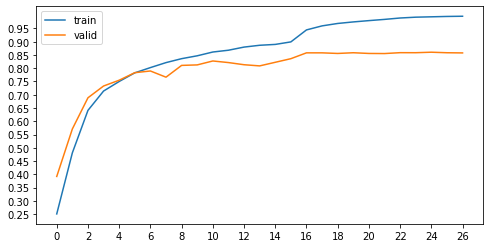

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

In [31]:
# 입력 image의 크기를 resize 값 만큼 증가. CIFAR10의 이미지가 32x32로 작아서 마지막 feature map의 크기가 1로 되어 모델 성능이 좋지 않음. 
# 마지막 feature map의 크기를 2로 만들기 위해 resize를 64로 하여 입력 이미지 크기를 변경. 단 메모리를 크게 소비하므로 64이상은 kernel이 다운됨. 
def get_resized_images(images, resize=64):
    image_cnt = images.shape[0]
    resized_images = np.zeros((images.shape[0], resize, resize, 3))
    for i in range(image_cnt):
        resized_image = cv2.resize(images[i], (resize, resize))
        resized_images[i] = resized_image
    
    return resized_images

In [32]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import numpy as np
import pandas as pd
import cv2

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception

# seed 를 설정해서 학습시마다 동일한 결과 유도. 불행히도 의도한 대로 동작하지 않음. 
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# 0 ~ 1사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels, scaling=True):
    
    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형. 
    if scaling:
        images = np.array(images/255.0, dtype=np.float32)
    else:
        images = np.array(images, dtype=np.float32)
        
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용 
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels, scaling=False)
    # OHE 적용 
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환 
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용. 
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels ) 

# 입력 image의 크기를 resize 값 만큼 증가. CIFAR10의 이미지가 32x32로 작아서 마지막 feature map의 크기가 1로 되어 모델 성능이 좋지 않음. 
# 마지막 feature map의 크기를 2로 만들기 위해 resize를 64로 하여 입력 이미지 크기를 변경. 단 메모리를 크게 소비하므로 64이상은 kernel이 다운됨. 
def get_resized_images(images, resize=64):
    image_cnt = images.shape[0]
    resized_images = np.zeros((images.shape[0], resize, resize, 3))
    for i in range(image_cnt):
        resized_image = cv2.resize(images[i], (resize, resize))
        resized_images[i] = resized_image
    
    return resized_images

def create_model(model_name='vgg16', verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    output = Dense(10, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    model.summary()
        
    return model

In [33]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

def do_cifar10_train_evaluation(image_size=IMAGE_SIZE, model_name='vgg16'):
    set_random_seed(2021)
    # CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성. 
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
    (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
        get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)
    print('데이터 세트 shape:', tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)
    
    # 만약 image_size가 32보다 크면 이미지 크기 재조정. 
    if image_size > 32:
        tr_images = get_resized_images(tr_images)
        val_images = get_resized_images(val_images)
        test_images = get_resized_images(test_images)
    
    # 학습/검증/테스트용 ImageDataGenerator와 flow로 pipeline 생성. 
    train_generator = ImageDataGenerator(
        horizontal_flip=True,
        rescale=1/255.0
    )
    valid_generator = ImageDataGenerator(rescale=1/255.0)
    test_generator = ImageDataGenerator(rescale=1/255.0)

    flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
    flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
    flow_test_gen = train_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
    
    # model_name 에 따른 모델 생성하고 모델 학습 및 검증 수행. 
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
    rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
    # 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
    ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
    
    tr_data_len = tr_images.shape[0]
    val_data_len = val_images.shape[0]
    history = model.fit(flow_tr_gen, epochs=40, 
                        steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), 
                        validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)),
                        callbacks=[rlr_cb, ely_cb])
    # 테스트 데이터 세트로 모델 성능 검증 
    evaluation_result = model.evaluate(flow_test_gen)
    print('테스트 데이터 세트 evaluation 결과:', evaluation_result)
    return history, evaluation_result

In [34]:
import gc

gc.collect()

8295

In [35]:
# 만약 image_size를 64로 하려면 반드시 RAM이 여유분이 충분히 있는지 확인
history, evaluation_result = do_cifar10_train_evaluation(image_size=64, model_name='xception')

데이터 세트 shape: (42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)
83683744/83683744 [==============================] - 1s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 15, 15, 32)   864         ['input_8[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 15, 15, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                     

In [36]:
print('테스트 데이터세트 검증 결과:', evaluation_result)

테스트 데이터세트 검증 결과: [0.3821974992752075, 0.9319999814033508]


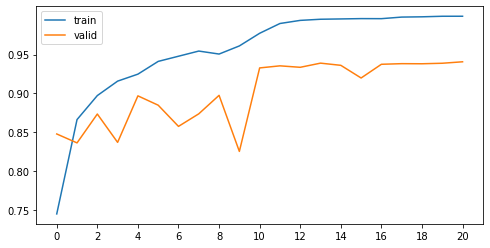

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)